In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.units as u

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'

In [10]:
hand_files = np.genfromtxt('hand_picked_super_files.txt', dtype='str')
len(hand_files)

247

In [11]:
df = pd.read_csv('1to13.cpa425_flare_out.csv')
df_param = pd.read_csv('1to13.cpa425_param_out.csv')

len(df), len(np.unique(df['file']))

(2430, 982)

In [12]:
hand_mask = np.isin(df['file'].values, hand_files)
df = df[hand_mask]
len(df), len(np.unique(df['file']))

(636, 247)

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


(1, 100000000.0)

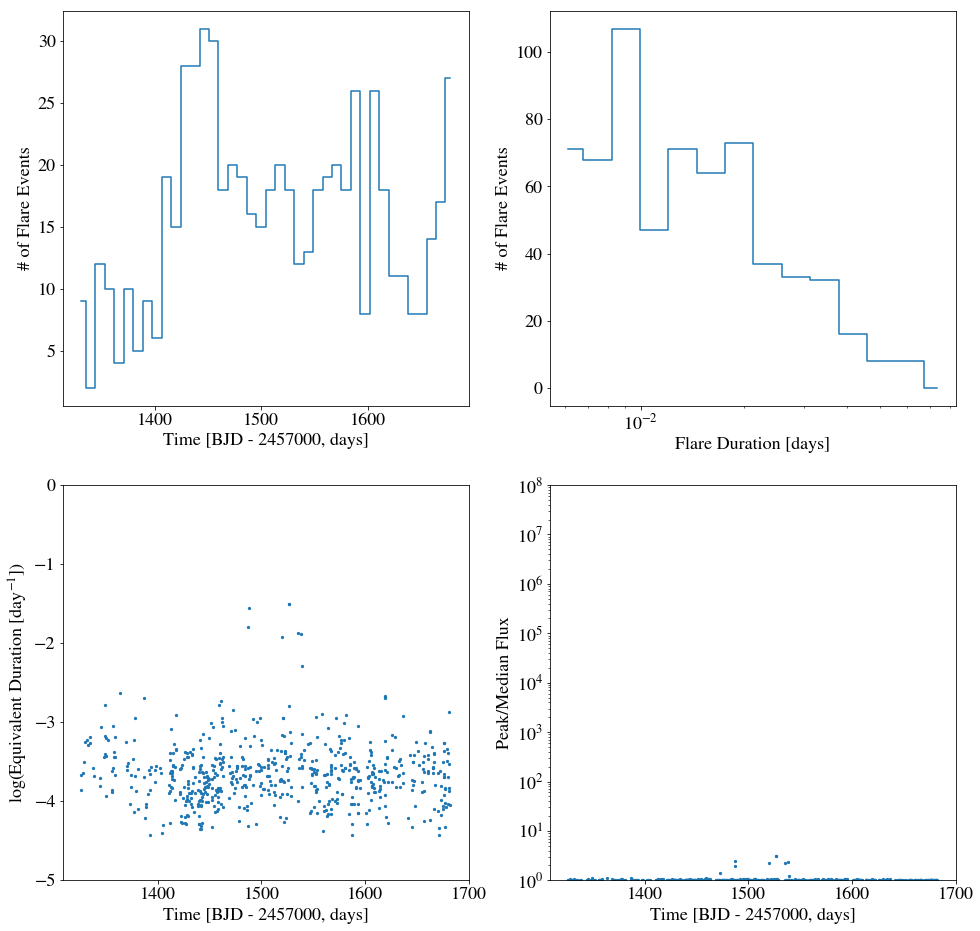

In [13]:
fig, axes = plt.subplots(figsize=(16,16), nrows=2, ncols=2)

hist, bins = np.histogram(df['t0'], bins=40)
bins = 0.5*(bins[1:] + bins[:-1])
axes[0][0].plot(bins, hist, linestyle='steps-mid')
axes[0][0].set_xlabel('Time [BJD - 2457000, days]')
axes[0][0].set_ylabel('# of Flare Events')

duration = df['t1'] - df['t0']
bins = np.logspace(np.log10(np.min(duration)), np.log10(np.max(duration)), num=15)
hist, bins = np.histogram(duration, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
axes[0][1].semilogx(bins, hist, linestyle='steps-mid')
axes[0][1].set_xlabel('Flare Duration [days]')
axes[0][1].set_ylabel('# of Flare Events')

bins = 0.5*(bins[1:] + bins[:-1])
y = np.log10(df['ed'])
yerr = 0.434*df['ed_err']/df['ed']
axes[1][0].scatter(df['t0'], y, s=5)
#axes[1][0].set_yscale('log')
axes[1][0].set_ylim(-5, 0)
axes[1][0].set_xlabel('Time [BJD - 2457000, days]')
axes[1][0].set_ylabel(r'log(Equivalent Duration [day$^{-1}$])')

bins = 0.5*(bins[1:] + bins[:-1])
axes[1][1].scatter(df['t0'], df['peak']/df['med'], s=5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Time [BJD - 2457000, days]')
axes[1][1].set_ylabel('Peak/Median Flux')
axes[1][1].set_ylim(1, 1e8)

In [14]:
# Measure flare energies
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
print(len(tic_gaia_table), len(df))
dfg = pd.merge(tic_gaia_table, df, on='TIC', how='right')
len(dfg), len(np.unique(dfg['file']))

128258 636


(636, 247)

In [15]:
ed = (dfg['ed'].values*u.day).to(u.s)
energy = (ed*dfg['lum']*u.erg/u.s).value
dfg['energy'] = energy

Text(0, 0.5, 'Number of Flares')

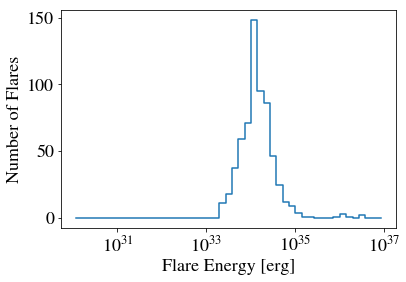

In [16]:
# Remember, we picked LCs where there was at least one superflare
# Can still have other flares along side that are not superflares

bins = np.logspace(30, 37)
hist, bins = np.histogram(energy[np.isfinite(energy)], bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')
plt.xlabel('Flare Energy [erg]')
plt.ylabel('Number of Flares')

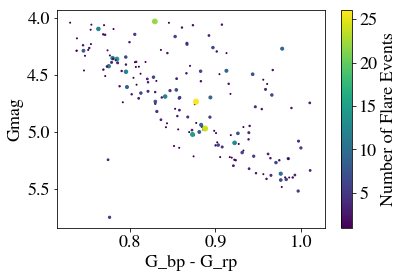

In [17]:
dfg_dup = dfg.drop_duplicates('TIC')
num_flares = np.empty(len(dfg_dup))
for idx in range(len(dfg_dup)):
    num_flares[idx] = len(dfg[dfg['TIC'] == dfg_dup.iloc[idx]['TIC']])

distance = dfg_dup['r_est']
M_G = dfg_dup['G_mag'] - 5*np.log10(dfg_dup['r_est']) + 5
plt.scatter(dfg_dup['G_BPbrmag'] - dfg_dup['G_RPmag'], M_G, s=num_flares, c=num_flares)
plt.gca().invert_yaxis()
plt.xlabel('G_bp - G_rp')
plt.ylabel('Gmag')
plt.colorbar(label='Number of Flare Events')

In [18]:
# Re-run the flare pipeline on these stars only using less restrictive CPA parameters
df = pd.read_csv('1to13.hand.cpa313_flare_out.csv')
df_param = pd.read_csv('1to13.hand.cpa313_param_out.csv')

len(df), len(np.unique(df['file']))

(1093, 247)

In [19]:
# Measure flare energies
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
print(len(tic_gaia_table), len(df))
df = pd.merge(tic_gaia_table, df, on='TIC', how='right')
len(df), len(np.unique(df['file']))

ed = (df['ed'].values*u.day).to(u.s)
energy = (ed*df['lum']*u.erg/u.s).value
df['energy'] = energy

128258 1093


In [20]:
from flareTools import id_segments
super_energy = 1e34
mask = (df['f_chisq'] < df['g_chisq']) & (df['f_chisq'] > 0) & (df['ed'] > 0) & (df['f_chisq'] < 100)
df = df[mask]

for filename in np.unique(df['file']):
    tstart = df[df['file'] == filename]['t0'].values
    tstop = df[df['file'] == filename]['t1'].values
    energy = df[df['file'] == filename]['energy'].values

    fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
    
    with fits.open(path+filename, mode='readonly') as hdulist:
        tess_bjd = hdulist[1].data['TIME']
        pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality = hdulist[1].data['QUALITY']
        
    smo = np.loadtxt(path+filename+'.gp')
    ok_cut = (quality == 0) & (~np.isnan(tess_bjd)) & (~np.isnan(pdcsap_flux)) & (~np.isnan(pdcsap_flux_error))
    
    dt_limit = 12/24 # 12 hours
    trim = 4/24 # 4 hours
    istart, istop = id_segments(tess_bjd[ok_cut], dt_limit, dt_trim=trim)

    time_c = np.array([])
    flux_c = np.array([])
    error_c = np.array([])

    for seg_idx in range(len(istart)):
        tess_bjd_seg = tess_bjd[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_seg = pdcsap_flux[ok_cut][istart[seg_idx]:istop[seg_idx]]
        pdcsap_flux_error_seg = pdcsap_flux_error[ok_cut][istart[seg_idx]:istop[seg_idx]]

        time_c = np.concatenate((time_c, tess_bjd_seg), axis=0)
        flux_c = np.concatenate((flux_c, pdcsap_flux_seg), axis=0)
        error_c = np.concatenate((error_c, pdcsap_flux_error_seg), axis=0)
        
    median = np.nanmedian(flux_c)
    
    axes[0].plot(time_c, flux_c/median)
    axes[0].plot(time_c, smo)
    axes[0].set_xlabel('Time [BJD - 2457000, days]')
    axes[0].set_ylabel('Flux [e-/s]')
    axes[0].set_title(filename)
    
    x = time_c
    y = flux_c/median - smo + 1
    axes[1].plot(x, y)
    for idx in range(len((tstart))):
        indices = np.where((x >= tstart[idx]) & (x <= tstop[idx]))[0]
        marker = 'x'
        # Is a superflare
        if energy[idx] > super_energy:
            marker = 'o'
        axes[1].plot(x[indices], y[indices], marker)
    axes[1].set_xlabel('Time [BJD - 2457000, days]')
    axes[1].set_ylabel('Normalized Flux')
    plt.savefig('/astro/store/gradscratch/tmp/scw7/tessData/plots/'+filename+'.png')
    plt.close()